# NL COVID 19 data exploration

- data from https://data.rivm.nl/covid-19/
- taken 19 July 2020

## Notes

- Given that daily reported numbers are in small quantities
(i.e. <100), changes represented in % changes
can be highly sensitive.
E.g. Changing from 1 to 5 is a 500% change.
- But % change is the only way to
compare change in qty across different slices
of data.
- So take those figures with a pinch of salt.
- That being said, we are looking for anomalies,
so a sufficiently large % change would signal
an abnormally large change.
- (Also, because I've just slapped this together in a
few hours + re-learning how to use pandas/matplotlib,
so i haven't put together a way to quickly
compare % change across many more slices of data -- see todo)

## todo

- helper functions to dry code
- plot graph that shows week-on-week daily % increase
- plot that graph for every week since beginning of data

In [21]:
import pandas as pd
import os
from matplotlib.pyplot import grid,plot,barh,xticks,yticks,legend,show
import numpy as np
from pprint import pprint

In [22]:
_DATADIR="../_data"

# There are two datasets
# _DATA_CASES is a CSV file containing data on nationally reported cases
# _DATA_CUMUL contains data on cumulative infections, hospitalizations, deaths
#_DATA_CASES="COVID-19_casus_landelijk.csv"
_DATA_CUMUL="COVID-19_aantallen_gemeente_cumulatief-2020-07-24.csv"

#cases = pd.read_csv(os.path.join(_DATADIR, _DATA_CASES), delimiter=";")
cumul = pd.read_csv(os.path.join(_DATADIR, _DATA_CUMUL), delimiter=";")

# set dtype of "Date_of_report" to pd.DatetimeTZDtype
# get date in YYYY-MM-DD by accessing
# cumul_ams["Date_of_report"].dt.date
cumul["Date_of_report"] = pd.to_datetime(cumul["Date_of_report"])
cumul.info()

cumul["Date_of_report"] = cumul["Date_of_report"].dt.normalize() # get date portion of datetime only
cumul.sort_values(by="Date_of_report",ascending=True,inplace=True)
# cumul["Date_of_report"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49178 entries, 0 to 49177
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date_of_report      49178 non-null  datetime64[ns]
 1   Municipality_code   47570 non-null  object        
 2   Municipality_name   47570 non-null  object        
 3   Province            49178 non-null  object        
 4   Total_reported      49178 non-null  int64         
 5   Hospital_admission  49178 non-null  int64         
 6   Deceased            49178 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 2.6+ MB


In [23]:
# NOT USED YET
#cases_ams = cases[cases["Municipal_health_service"].isin(["GGD Amsterdam"])]
#cases_ams.tail()

In [24]:
# We want only cases from Amsterdam:

cumul_ams = cumul[cumul["Municipality_name"].isin(["Amsterdam"])]

# create new column for day of week

cumul_ams.insert(len(cumul_ams.columns), "Day",cumul_ams["Date_of_report"].dt.day_name())
cumul_ams["Day"].astype("str")

# create new column for week number
cumul_ams.insert(len(cumul_ams.columns), "Week", cumul_ams["Date_of_report"].dt.week)
cumul_ams["Week"]

# cumul_ams["Deceased"][-30:]

109      11
476      11
843      11
1210     12
1577     12
         ..
47452    30
47819    30
48186    30
48553    30
48920    30
Name: Week, Length: 134, dtype: int64

In [25]:
# create working df with:
# date, cumulative day of week, week number, reports

cumuldf = cumul_ams[["Date_of_report","Day","Week","Total_reported"]]
cumuldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 109 to 48920
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date_of_report  134 non-null    datetime64[ns]
 1   Day             134 non-null    object        
 2   Week            134 non-null    int64         
 3   Total_reported  134 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.2+ KB


In [26]:
# compare day on day increments/deltas

def get_daily_delta(df):
    daily_delta_column = []
    rep = df["Total_reported"]
    for i in range(0,len(df["Total_reported"])):
        if i == 0:
            daily_delta_column.append(0)
            continue # skip this index
        daily_delta_column.append(rep.iloc[i]-rep.iloc[i-1])

    return daily_delta_column

daily_delta = get_daily_delta(cumuldf)

# add daily deltas to df

cumuldf.insert(len(cumuldf.columns),"Daily_delta",daily_delta)

In [27]:
cumuldf.tail()

,Date_of_report,Day,Week,Total_reported,Daily_delta
47452,2020-07-20,Monday,30,2852,28
47819,2020-07-21,Tuesday,30,2873,21
48186,2020-07-22,Wednesday,30,2891,18
48553,2020-07-23,Thursday,30,2906,15
48920,2020-07-24,Friday,30,2925,19


In [28]:
def plot_daily_delta_for_last_n_weeks(df, n=3):
    """
    Plots n number of weeks
    worth of daily deltas in one line chart

    :param df:
    :type df: pandas.DataFrame
    :param n: Last n weeks
    :type n: int
    :return: None
    """
    grid(True)
    xticks(rotation="vertical")
    yticks(np.arange(0, df["Daily_delta"].max(), step=1))

    for week in range(0,n):
        df_week = df["Week"]
        this_week = df[df_week == df_week.max()-week]
        week_start = this_week.iloc[0]["Date_of_report"]
        week_start_d_m = f"{week_start.day}/{week_start.month}"
        week_end = this_week.iloc[-1]["Date_of_report"]
        week_end_d_m = f"{week_end.day}/{week_end.month}"

        plot(this_week["Day"],this_week["Daily_delta"],label=f"{week_start_d_m} – {week_end_d_m}")
    legend()

### Plot day to day change in reported cases, by week

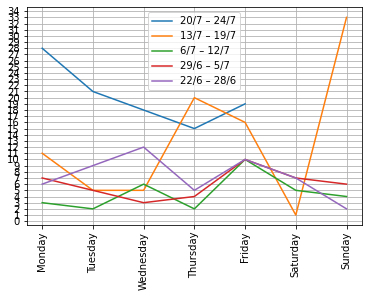

,Date_of_report,Week,Daily_delta,Total_reported
46718,2020-07-18,29,1,2791
47085,2020-07-19,29,33,2824
47452,2020-07-20,30,28,2852
47819,2020-07-21,30,21,2873
48186,2020-07-22,30,18,2891
48553,2020-07-23,30,15,2906
48920,2020-07-24,30,19,2925


In [29]:
plot_daily_delta_for_last_n_weeks(cumuldf, 5)
show()

cumuldf[["Date_of_report","Week","Daily_delta","Total_reported"]].tail(7)

In [30]:
def plot_weekly_delta_for_last_n_weeks(df, n):
    """
    Plot the weekly delta for the last n weeks

    :param df: dataframe
    :type df: pandas.DataFrame
    :param n: Last n weeks
    :type n: int
    :return: Dict
    """

    weekly_delta = {}
    for week in range(0,n):
        if df["Week"].max() < week:
            print(f"Week no. {df['Week'].max() - week} does not exist.")
            continue

        this_week_num = df["Week"].max() - week
        week_delta = df[df["Week"] == this_week_num]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_delta[f"Week {this_week_num}"] = 0
            continue
        else:
            weekly_delta[f"Week {this_week_num}"] = week_delta
            continue
    return weekly_delta



### Plot week-on-week change in reported cases

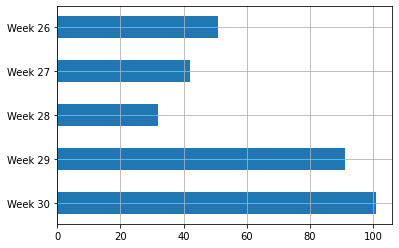

{'Week 26': 51, 'Week 27': 42, 'Week 28': 32, 'Week 29': 91, 'Week 30': 101}


In [31]:
weekly_delta = plot_weekly_delta_for_last_n_weeks(cumuldf, 5)
grid(True)
barh(list(weekly_delta.keys()), width=np.array(list(weekly_delta.values())),height=0.5)
show()
pprint(weekly_delta)

In [39]:
def weekly_percentage_incr_for_last_n_weeks(df, n):
    weekly_percent_delta = {}
    for week in range(0,n):
        if df["Week"].max() < week:
            print(f"Week no. {df['Week'].max() - week} does not exist.")
            continue

        this_week_num = df["Week"].max() - week
        week_delta = df[df["Week"] == this_week_num]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_percent_delta[f"Week {this_week_num}"] = 0
            continue
        else:
            last_week_delta = df[df["Week"] == (this_week_num-1)]["Daily_delta"].sum()
            weekly_percent_delta[f"Week {this_week_num}"] = ((week_delta-last_week_delta)/last_week_delta)*100

    return weekly_percent_delta


### Plot week-on-week percentage change in reported cases

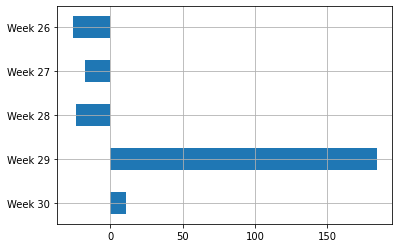

{'Week 26': -26.08695652173913,
 'Week 27': -17.647058823529413,
 'Week 28': -23.809523809523807,
 'Week 29': 184.375,
 'Week 30': 10.989010989010989}


In [40]:
grid(True)
weekly_percent_delta = weekly_percentage_incr_for_last_n_weeks(cumuldf,5)
barh(list(weekly_percent_delta.keys()), width=np.array(list(weekly_percent_delta.values())),height=0.5)
show()
pprint(weekly_percent_delta)

## Cumulative reported cases for the last 30 days

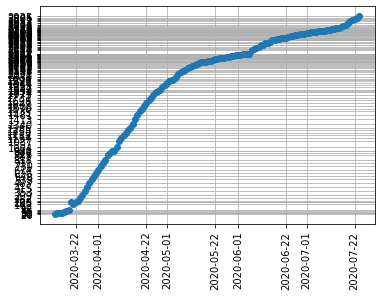

In [34]:
# figure for last 30 days
last_30 = cumuldf.loc[-30:,]
from matplotlib.pyplot import plot_date

grid(True)
xticks(rotation="vertical")
yticks(last_30["Total_reported"])
plot_date(last_30["Date_of_report"], last_30["Total_reported"],xdate=True )
show()